$
\def\D{\mathcal{D}}
\def\ipar{m}
\def\R{\mathbb{R}}
\def\del{\partial}
\def\vec{\bf}
\def\priorm{\mu_0}
\def\C{\mathcal{C}}
\def\Acal{\mathcal{A}}
\def\postm{\mu_{\rm{post}}}
\def\iparpost{\ipar_\text{post}}
\def\obs{\vec{d}} 
\def\yobs{\obs^{\text{obs}}}
\def\obsop{\mathcal{B}}
\def\dd{\vec{\bar{d}}}
\def\iFF{\mathcal{F}}
\def\iFFadj{\mathcal{F}^*}
\def\ncov{\Gamma_{\mathrm{noise}}}
$
# Bayesian initial condition inversion in an advection-diffusion problem 

In this example we tackle the problem of quantifying the uncertainty in the solution of an inverse problem governed by a parabolic PDE via the Bayesian inference framework. The underlying PDE is a time-dependent advection-diffusion equation in which we seek to infer an unknown initial condition from spatio-temporal point measurements.

### The Bayesian inverse problem:

Following the Bayesian framework, we utilize 
a Gaussian prior measure $\priorm = \mathcal{N}(\ipar_0,\C_0)$,
with $\C_0=\Acal^{-2}$ where $\Acal$ is an elliptic differential operator and use an additive
Gaussian noise model. Therefore, the solution of the Bayesian inverse
problem is the posterior measure, $\postm = \mathcal{N}(\iparpost,\C_\text{post})$ with
$\iparpost$ and $\C_\text{post}$.

- The posterior mean $\iparpost$ is characterized as the minimizer of

$$
\begin{aligned}
& \mathcal{J}(\ipar) :=
  \frac{1}{2} \left\| \mathcal{B}u(\ipar) -\obs  \right\|^2_{\ncov^{-1}}
  + \frac 12 \left\| \Acal(\ipar - \ipar_0 \right)\|^2_{L^2(\D)},
\end{aligned}
$$

which can also be interpreted as the regularized functional to be
minimized in deterministic inversion. The observation operator $\mathcal{B}$ extracts the values of the forward solution $u$ on a set of
locations $\{\vec{x}_1, \ldots, \vec{x}_n\} \subset \D$ at
times $\{t_1, \ldots, t_N\} \subset [0, T]$.

- The posterior covariance $\C_{\text{post}}$ is the inverse of the Hessian of $\mathcal{J}(\ipar)$, i.e.,

$$
\C_{\text{post}} = (\iFFadj \ncov^{-1} \iFF + \C_0^{-1})^{-1}.
$$


### The forward problem:

The PDE in the parameter-to-observable map $\iFF$ models diffusive transport
in a domain $\D \subset \R^d$ ($d \in \{2, 3\}$):

$$
\begin{split}
u_t - \kappa\Delta u + \bf{v} \cdot \nabla u &= 0     & \quad \text{in } \D\times(0,T),\\
                                 u(\cdot, 0) &= \ipar & \quad \text{in } \D,\\
                \kappa \nabla u\cdot \vec{n} &= 0     & \quad \text{on } \partial\D \times (0,T).
\end{split}
$$

Here, $\kappa > 0$ is the diffusion coefficient and $T > 0$ is the final
time. The velocity field
$\vec{v}$ is computed by solving the following steady-state
Navier-Stokes equation with the side walls driving the flow:

$$
\begin{aligned}
- \frac{1}{\operatorname{Re}} \Delta \bf{v} + \nabla q + \bf{v} \cdot \nabla \bf{v} &= 0 &\quad&\text{ in }\D,\\
\nabla \cdot \bf{v} &= 0 &&\text{ in }\D,\\
\bf{v} &= \bf{g} &&\text{ on } \partial\D.
\end{aligned}
$$

Here, $q$ is pressure, $\text{Re}$ is the Reynolds number. The Dirichlet boundary data
$\vec{g} \in \R^d$ is given by 
$\vec{g} = \vec{e}_2$ on the left wall of the domain, 
$\vec{g}=-\vec{e}_2$ on the right wall,  and $\vec{g} = \vec{0}$ everywhere else.

## 1. Load modules

In [1]:
import dolfin as dl
import numpy as np
import scipy.linalg as la
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
%matplotlib inline

import linear_operators
import hessian_action
import cost_functions

## 2. Import Mesh and Velocity Field


 Parameter Dimension:       2023



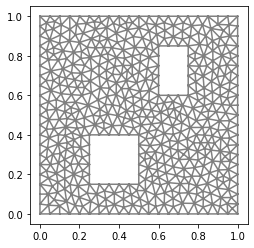

In [2]:
mesh = dl.Mesh("./ad_20.xml")
V = dl.FunctionSpace(mesh, "Lagrange", 2)
print('\n Parameter Dimension: {0:10d}\n'.format(V.dim()))
dl.plot(mesh)

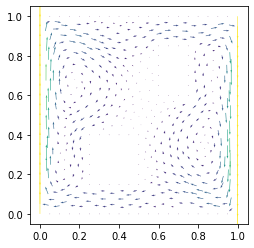

In [3]:
# load velocity
vel_space = dl.VectorFunctionSpace(mesh, "Lagrange", 2) # Don't change this without changing ns_solver
velocity = dl.Function(vel_space)
dl.File("./velocity_field.xml.gz") >> velocity
dl.plot(velocity)

## 3. Construct the true parameter and true state

Constructing true parameter and state

UFL conditions cannot be evaluated as bool in a Python context.


UFLException: UFL conditions cannot be evaluated as bool in a Python context.

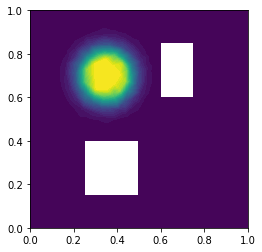

In [5]:
print('Constructing true parameter and state\n')
u0_true = dl.interpolate(dl.Expression('min(0.5,exp(-100*(pow(x[0]-0.35,2) +  pow(x[1]-0.7,2))))', degree=5),V)
dl.plot(u0_true)

# Initialize forward pde solvers and solve for true state
dt = 0.01
T_final = 3
kappa = 0.001
adv_diff_solver = linear_operators.Adv_diff_solver(mesh,V,velocity,vel_space,dt,kappa,T_final)
uf_true = adv_diff_solver.F_mult(u0_true.vector())
uf_plot = dl.Function(V)
uf_plot.vector().set_local(uf_true.get_local())
dl.plot(uf_plot)

## 4. Take Observations of true state

Constructing observation operator



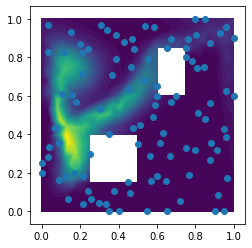

In [6]:
# Initialize observation operator and measurements
print('Constructing observation operator\n')
noise_signal_ratio = 0.05
nObs = 100
obs_operator = linear_operators.Observation_operator(nObs,mesh,V,adv_diff_solver)
obs_true = obs_operator.apply_obs(uf_true)
sigma_vec = noise_signal_ratio*np.max(obs_true)*np.ones(obs_operator.nObs)
obs_real = obs_true + np.random.normal(0.0,noise_signal_ratio*np.max(obs_true),nObs)
noise_cov = linear_operators.Noise_covariance(sigma_vec)

dl.plot(uf_plot)
plt.scatter(obs_operator.obs_vert_coor[:,0],obs_operator.obs_vert_coor[:,1])
plt.show()

## 5. Define the Prior

In [8]:
prior_mean = dl.Function(V).vector()
prior_mean.set_local(0.5*np.ones(V.dim()))
prior_cov = linear_operators.BiLaplacian_prior(V,1.0,8.0)

## 6. Initialize the cost function, gradient, and Hessian


 Total forward+adjoint evaluations:         63



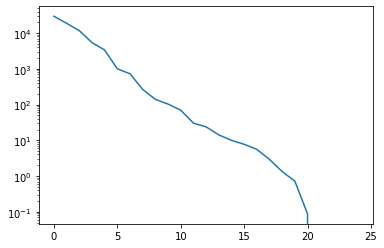

In [9]:
# specify a cost function and Hessian
cost = cost_functions.sb_linear_cost(prior_mean,prior_cov,adv_diff_solver,obs_operator,noise_cov,obs_real)

Hessian_full = hessian_action.full_Hessian_sb(prior_cov,adv_diff_solver,obs_operator,noise_cov)
Hessian_reduced = hessian_action.reduced_Hessian(V,25,5,prior_cov,adv_diff_solver,obs_operator,noise_cov)
print('\n Total forward+adjoint evaluations: {0:10d}\n'.format(adv_diff_solver.forward_count))

plt.semilogy(Hessian_reduced.eigenvalues)
plt.show()

## 7. Run optimization to find $\lambda_{\text{MAP}}$

In [10]:
# construct numpy wrapper for Hessian
H_temp_vec = dl.Function(V).vector()
def H_vec_prod(x):
    H_temp_vec.set_local(x)
    y = Hessian_full.H_mult(H_temp_vec)
    return y.get_local()
Hv = spla.LinearOperator((V.dim(),V.dim()),matvec=H_vec_prod)

def H_inv_vec_prod(x):
    H_temp_vec.set_local(x)
    y = Hessian_reduced.H_sb_inv_mult(H_temp_vec)
    return y.get_local()
Hinv = spla.LinearOperator((V.dim(),V.dim()),matvec=H_inv_vec_prod)

def prior_prod(x):
    H_temp_vec.set_local(x)
    y = prior_cov.mult_full(H_temp_vec)
    return y.get_local()
prior_op = spla.LinearOperator((V.dim(),V.dim()),matvec=prior_prod)

cost = cost_functions.sb_linear_cost(prior_mean,prior_cov,adv_diff_solver,obs_operator,noise_cov,obs_real)
class cg_counter():
    def __init__(self):
        self.count = 0
    def incr(self,x):
        self.count += 1
# set optimization parameters
G_tol = 1e-6
J_mis_tol = 1e-12
iter_max = 200
max_backtrack = 10
armijo_param = 1.0e-4
ii = 0
u_new = dl.Function(V)
converged = False
# set initial guess
u0_map = dl.Function(V)

# Begin optimization
print('\n {0:10} \t {1:10} \t {2:10} \t {3:10} \t {4:10} \t {5:10} \n'.format('iter','J_mis','J_reg','||G||','n_backtrack','CG iter'))
while not converged:
    # Evaluate cost function
    if (ii == 0):
        J_mis,J_reg,G = cost.evaluate(u0_map.vector())
        J = J_mis + J_reg
        G_norm = dl.norm(G,'L2')
        print('\n {0:10d} \t {1:10e} \t {2:10e} \t {3:10e} \t {4:10} \t {5:10} \n'.format(ii,J_mis,J_reg,G_norm,'--','--'))

    # Find Newton direction
    counter = cg_counter()
#    x0 = -1.0*G.get_local()/la.norm(G.get_local(),2)
    p,cg_info = spla.cg(Hv,-1.0*G.get_local(),maxiter=200,tol=1e-3,M=Hinv,callback=counter.incr,atol=1e-8)

    # perform backtracking line search
    wolfe_condition_1 = False #Armijo rule
    step_size = 1.0
    n_backtrack = 0
    while not wolfe_condition_1:
        u_new_np = u0_map.vector().get_local()+step_size*p
        u_new.vector().set_local(u_new_np)

        J_mis_new,J_reg_new,G_new = cost.evaluate(u_new.vector())
        J_new = J_mis_new + J_reg_new

        if (J_new <= (J+armijo_param*step_size*np.dot(p,G.get_local()))):
            wolfe_condition_1 = True
            u0_map.vector().set_local(u_new_np)
        else:
            step_size = step_size*0.5
            n_backtrack = n_backtrack + 1

            if (n_backtrack >= max_backtrack):
#       raise ValueError('Backtracking line search failed!')
                print('\n backtracking line search failed!\n')
                wolfe_condition_1 = True
                converged = True

    J_mis = J_mis_new
    J_reg = J_reg_new
    J = J_new
    G = G_new
    ii = ii +1

    G_norm = dl.norm(G,'L2')

    if (G_norm < G_tol) or (ii >= iter_max) or (J_mis < J_mis_tol):
        converged = True

    print('\n {0:10d} \t {1:10e} \t {2:10e} \t {3:10e} \t {4:10d} \t {5:10d}'.format(ii,J_mis,J_reg,G_norm,n_backtrack, counter.count))

print('\n Total forward+adjoint evaluations: {0:10d}\n'.format(adv_diff_solver.forward_count))


 iter       	 J_mis      	 J_reg      	 ||G||      	 n_backtrack 	 CG iter    


          0 	 1.754325e+03 	 7.200000e+00 	 2.039756e+04 	 --         	 --         


          1 	 4.902662e+01 	 4.698789e+01 	 5.529898e+02 	          0 	        200

          2 	 5.014089e+01 	 4.314675e+01 	 7.393895e+02 	          0 	        200

          3 	 4.882357e+01 	 4.380785e+01 	 2.122772e+02 	          0 	        200

          4 	 4.876217e+01 	 4.371232e+01 	 2.261675e+02 	          0 	        200

          5 	 4.858547e+01 	 4.380853e+01 	 1.189528e+02 	          0 	        200

          6 	 4.873862e+01 	 4.358061e+01 	 1.149487e+02 	          0 	        200

          7 	 4.853183e+01 	 4.374159e+01 	 2.590497e+01 	          0 	        200

          8 	 4.854087e+01 	 4.370959e+01 	 1.134617e+01 	          0 	        200

          9 	 4.851635e+01 	 4.371650e+01 	 2.901842e+01 	          0 	        200

         10 	 4.845346e+01 	 4.374873e+01 	 5.204747e+01 	          0 	     

## Results: The MAP point

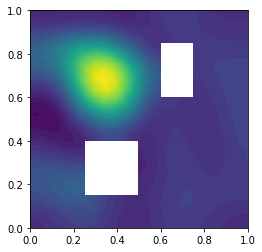

In [11]:
dl.plot(u0_map)

## Results: The recovered state

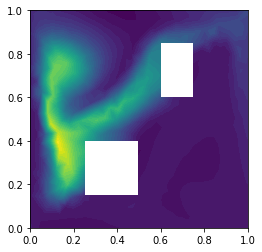

In [12]:
u_pf_map = dl.Function(V)
u_pf_map.vector().set_local(adv_diff_solver.F_mult(u0_map.vector()).get_local())
dl.plot(u_pf_map)